2017250004 김민규

##기본설정

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

%matplotlib inline 

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

np.random.seed(11)

##데이터 준비

삶의 만족도와 1인당 GDP내용을 가지고 있는 데이터를 다운받는다.

In [ ]:
datapath = os.path.join("notebooks", "datasets", "lifesat", "")

import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2020.csv", "gdp_per_capita_2020.xlsx"):
    print("다운로드:", filename)
    url = DOWNLOAD_ROOT + "notebooks/datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

다운로드: oecd_bli_2020.csv
다운로드: gdp_per_capita_2020.xlsx


csv파일과 xlsx파일을 읽어와서 보기 편하게 데이터셋으로 만든다. "INEQUALITY" 특성이 "TOT"로 정해진 데이터만 가져온 후에 pivot() 메서드를 이용하여 국가별 삶의 질을 평가하는 데에 사용되는 지표("Indicator")를 열(columns)로 사용하는 데이터프레임으로 저장한다. 

In [ ]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2020.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

In [ ]:
gdp_per_capita = pd.read_excel(datapath+"gdp_per_capita_2020.xlsx", thousands=',', na_values="n/a")
gdp_per_capita.rename(columns={2020: "GDP per capita"}, inplace=True) # 2020 컬럼 이름을 "GDP per capita" 로 변경 
gdp_per_capita.set_index("Country", inplace=True)

두 데이터셋을 병합시킨다.

In [ ]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)

##선형 관계

뒤에서 모델의 적합성을 살펴보기 위해 고의로 7개 국가의 데이터를 제외 시킨다.

In [ ]:
remove_indices = [1, 2, 4, 6, 37, 38, 39]
keep_indices = list(set(range(40)) - set(remove_indices))

# 7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터
sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices] 

# 제외된 7개 국가의 1인당 GGP와 삶의 만족도 데이터
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

제외된 7개 국가의 데이터를 제외한 국가들의 1인당 GDP와 삶의 만족도 사이의 관계를 산점도로 나타낸다. 아래에 언급된 5개 국가는 빨간색 점으로 표시한다.

헝가리(Hungary)

대한민국(Korea)

프랑스(France)

호주(Australia)

미국(United States)

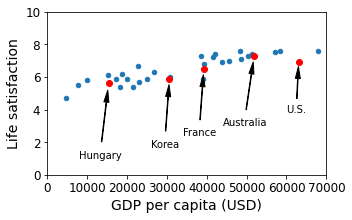

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 70000, 0, 10])

# 언급된 5개 국가명 명기 좌표
position_text = {
  "Hungary": (8000, 1),
  "Korea": (26000, 1.7),
  "France": (34000, 2.4),
  "Australia": (44000, 3.0),
  "United States": (60000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    # 5개 국가 산점도 그리기
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인해본다.

In [ ]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,15372.885,5.6
Korea,30644.427,5.9
France,39257.434,6.5
Australia,51885.466,7.3
United States,63051.398,6.9


위에서 살펴본 산점도에 따르면 어느정도 선형 관계를 가지는 것으로 보인다. 아래에서는 파란색 실선이 가장 적합해 보인다.

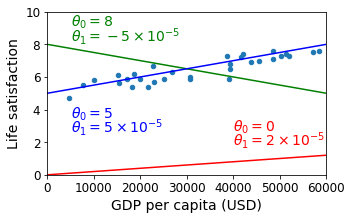

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 5 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 5$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
plt.show()

##선형 회귀 모델 훈련

삶의 만족도는 다음과 같이 표현할 수 있다.   

$$
\text{삶의만족도} = \theta_0 + \theta_1 \times \text{1인당GDP}
$$
저 절편과 기울기를 사이킷런 패키지의 `linear_model` 모듈에 포함된 `LinearRegression` 클래스를 활용하여 학습시킬 예정이다.   
다음 코드는 1인당 GDP를 통해 삶의 만족도를 예측하는 훈련을 진행한다.

In [ ]:
from sklearn import linear_model

# 선형회귀 모델 지정
lin1 = linear_model.LinearRegression()

# 훈련 데이터셋 지정
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
lin1.fit(Xsample, ysample)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

훈련한 모델의 최적의 절편과 기울기는 각각 `intercept_[0]`, `coef_[0]`에 저장된다.

In [ ]:
# 예측된 최적의 직선에 대한 정보: 절편과 기울기
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

t0, t1

(5.071121853750363, 4.1410177424136694e-05)

구해진 절편과 기울기를 이용해서 직선을 그려보면 다음과 같다. 위에서 임의로 지정한 직선도 비슷했지만 학습된 절편과 기울기로 그린 직선이 더 정확해 보인다.

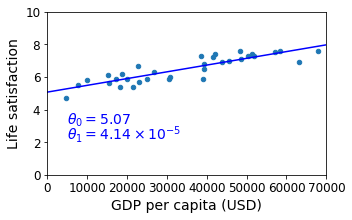

In [ ]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 70000, 0, 10])

# 직선 그리기
X=np.linspace(0, 70000, 1000)
plt.plot(X, t0 + t1*X, "b")
# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

plt.show()

키프러스(cyprus)라는 나라는 1인당 GDP만 알려져있는데 이를 통해 삶의 만족도를 예측하면 다음과 같다.

In [ ]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)

26240.048


`predict`메소드를 이용하여 예측해보면 약 6.16정도로 예측된다.

In [ ]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

6.157726897048226

예측값은 위에서 그렸던 직선상에 정확히 위치하는 것을 볼 수 있다.

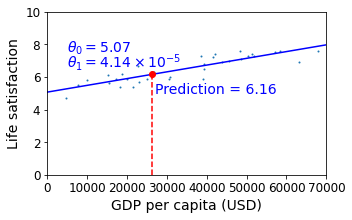

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")

# 예측된 최적의 직선
X=np.linspace(0, 70000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 70000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

# 키프러스에 대한 삶의 만족도 예측값

# 빨간 점선 그리기
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(27000, 5.0, r"Prediction = 6.16", fontsize=14, color="b")

# 예측 지점 좌표 찍기(빨간색)
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
plt.show()

##대표성 없는 훈련 데이터

앞서 7개 국가의 데이터를 훈련에서 제외시킨 후에 선형회귀 모델을 훈련시켰다.
이제 7개 국가를 포함해서 훈련시켜 볼 것이다.
제외된 7개 국가의 데이터는 다음과 같다.

In [ ]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Colombia,5207.238,6.3
Brazil,6450.451,6.4
Mexico,8069.104,6.5
Chile,12612.322,6.5
Ireland,79668.502,7.0
Switzerland,81867.462,7.5
Luxembourg,109602.322,6.9


7개의 국가들을 아래 도표에서 표기할 때 사용할 좌표이다.

In [ ]:
position_text2 = {
    "Colombia": (1000, 9.0),
    "Brazil": (15000, 9.0),
    "Mexico": (16000, 8.0),
    "Chile": (34000, 9.0),
    "Ireland": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (100000, 3.0),
}

7개의 국가를 제외했을 때와 포함했을 때의 훈련 결과를 비교해본다. 7개의 국가를 포함하니 기존의 직선과는 많이 달라진 것을 보아 1인당 GDP와 삶의 만족도 사이의 관계를 선형 모델로 표현하는 것은 적절하지 않은 것으로 보인다.

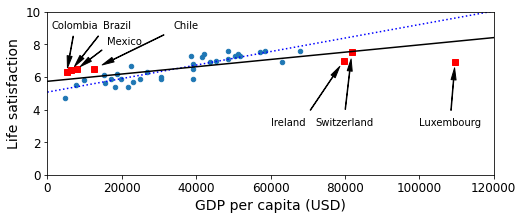

In [ ]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 120000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 120000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 120000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

plt.show()

##과대적합

훈련된 모델이 훈련데이터에는 너무나도 잘 맞지만 새로운 데이터에 대해서는 잘 작동하지 않을 때 해당 모델이 훈련데이터에 __과대적합__되었다고 말한다.   
예를 들어서 위에서 살펴봤듯이 1인당 GDP와 삶의 만족도의 관계를 선형 모델로 표현하는 것은 적절하지 않아보였다. 그래서 아래 도표와 같이 고차항 다항 회귀로 표현하면 해당 데이터에는 매우 적절해 보이지만 새로운 데이터가 들어오면 엉뚱한 결과를 예측할 것이다.

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


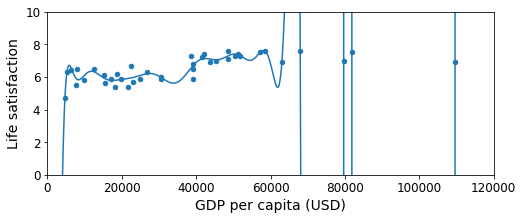

In [ ]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 120000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
plt.show()

훈련 세트에 잡음이 많거나 양이 충분하지 않으면 별로 상관 없는 특성을 이용하여 훈련을 시도할 수도 있다. 아래 코드에서 볼 수 있듯이 국가 이름에 W가 포함돼있으면 삶의 만족도가 높은 편이다.

In [ ]:
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.3
Norway         7.6
Switzerland    7.5
Name: Life satisfaction, dtype: float64

하지만 W가 국가명에 포함돼있는 나라가 모두 삶의 만족도가 높다고 할 수 없다. 아래에서 볼 수 있듯이 W가 포함돼 있지만 1인당 GDP가 매우 낮은 나라도 있는 것이 보인다. 

In [ ]:
#gdp_per_capita에 float 타입이 섞여있어서 upper와 for문이 동작하지 않아 타입을 구분할 수 있도록 type(c)==str을 사용
gdp_per_capita.loc[[c for c in gdp_per_capita.index if type(c)==str and "W" in c.upper()]].head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Botswana,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6557.505,2017.0
Eswatini,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3414.805,2017.0
Kuwait,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",22252.431,2018.0
Malawi,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",399.097,2011.0
New Zealand,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",38675.319,2019.0


##모델 규제

과대적합의 위험을 감소 시키기 위해 모델에 제약을 가하는 것을 __규제__라고 한다.   
- 빨강 파선: 7개 국가 포함 예측 선형 모델   
- 파랑 점선: 7개 국가 제외 예측 선형 모델   
- 파랑 실선: 7개 국가 제외 규제 적용 예측 선형 모델   

규제는 릿지(Ridge)를 사용했다. 7개의 국가를 제외하고도 규제를 가하면 7개의 국가를 포함했을 때와 차이가 줄어든 것을 볼 수 있다.

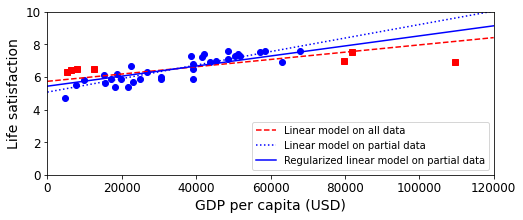

In [ ]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

# 7개 국가 제외 데이터 산점도(파랑 동그라미)
plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
# 제외된 7개 국가 산점도(빨강 네모)
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

# 7개 국가 포함 예측 선형 모델 그래프(빨강 파선)
X = np.linspace(0, 120000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
# 7개 국가 제외 예측 선형 모델 그래프(파랑 점선)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

# 릿지(Ridge) 규제 적용 훈련: 7개 국가 제외 데이터 대상
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
# 릿지 규제 적용 예측 선형 모델 그래프(파랑 실선)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 120000, 0, 10])
plt.xlabel("GDP per capita (USD)")
plt.show()

##사례 기반 학습

키프러스 국가의 삶의 만족도를 사례 기반 학습으로 예측하기 위해 1인당 GDP가 키프러스와 가장 가까운 국가들의 삶의 만족도를 활용할 수 있다. 키프러스와 1인당 GDP가 가장 가까운 세 나라는 다음과 같다.

In [ ]:
sample_data[11:14]

,GDP per capita,Life satisfaction
Country,,
Estonia,22985.858,5.7
Slovenia,25038.792,5.9
Spain,26831.629,6.3


이 세 나라의 삶의 만족도의 평균을 구하면 약 5.97이 나온다.

In [ ]:
(5.7 + 5.9 + 6.3)/3

5.966666666666668

위에서 설명한 알고리즘은 __k-최근접 이웃__이라고 한다. 사이킷런에서 제공하는 k-최근접 이웃 회귀 모델을 적용해도 동일한 결과가 나온다.   
`n_neighbors=3` : 예측할 데이터와 가장 가까운 3개의 데이터를 이용한다는 의미

In [ ]:
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
model.fit(X, y)

# 키프러스 국가에 대한 예측하기
X_new = np.array([[26240.048]])  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[5.966666666666668]]

[[5.96666667]]
